<a href="https://colab.research.google.com/github/DmitriyKhodykin/USFinancials/blob/main/feature_engeneering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ПРОЕКТ: US Financials

Пакет для инжиниринга фичей

## Пространство имен

In [ ]:
# Импортры

## Постоянное хранилище данных
from google.colab import drive

## Время и дата
import datetime

## Таблицы и вычисления
import numpy as np
import pandas as pd

## Визуализация данных
import seaborn as sns
from seaborn import heatmap
import matplotlib.pyplot as plt

## Утилиты
import warnings
from sklearn import preprocessing

In [ ]:
# Хранение и загрузка данных
drive.mount('/content/drive')
work_dir = '/content/drive/My Drive/Models/USFinancials'
data_dir = '/content/drive/My Drive/Data/USFinancials'

Mounted at /content/drive


## Часто используемый код

In [ ]:
def cols_to_datetime(df: pd.DataFrame, cols: list) ->  pd.DataFrame:
    """Для преобразования столбцов датафрейма к формату дата-время
    по списку передаваемых в функцию наименований столбцов
    """
    for i in cols:
        df[i] = pd.to_datetime(df[i])
    return df

In [ ]:
def show_filing_period(df: pd.DataFrame, feature: str):
    """Распределение отклонений по выпуску отчетности
    """
    df_copy = df.copy()
    df_copy['delta'] = df_copy[feature] - df_copy['date']
    df_copy['delta'] = df_copy['delta'].dt.days
    sns.set_theme()
    warnings.filterwarnings('ignore')
    return sns.distplot(df_copy[df_copy['delta'] < 100]['delta'])

## Загрузка данных

### Stock

In [ ]:
# Котировки акций, очищенные от рынного шума
# т.е. котировок акций к котировке SNP500
stock = pd.read_parquet(f'{work_dir}/US_stocks_hist_data.parquet')

In [ ]:
stock['date'] = stock.index
stock.head(3)

ticker,A,AA,AAALF,AAALY,AABB,AABVF,AACAF,AACAY,AACG,AACQ,AACQU,AACQW,AACS,AACTF,AAEEF,AAGC,AAGEF,AAGFF,AAGH,AAGIY,AAGRY,AAIC,AAIGF,AAIIQ,AALBF,AAMAF,AAMC,AAME,AAMMF,AAMTF,AAN,AANNF,AAOI,AAON,AAP,AAPJ,AAPL,AAPT,AASL,AASP,...,ZRSEF,ZRVT,ZS,ZSAN,ZSHGY,ZSTN,ZSYC,ZTCOF,ZTCOY,ZTLLF,ZTMUF,ZTNO,ZTO,ZTS,ZTSTF,ZULU,ZUMRF,ZUMZ,ZUO,ZURVY,ZVLO,ZVO,ZVTK,ZVZZT,ZWBC,ZWRKU,ZWZZT,ZXAIY,ZXZZT,ZYJT,ZYME,ZYNE,ZYQG,ZYRX,ZYXI,ZZHGF,ZZLL,ZZZOF,^GSPC,date
1970-03-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-03-25
1970-03-26,NaN,0.985414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1970-03-26
1970-03-30,NaN,1.012895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1970-03-30


In [ ]:
print('Количетво строк:', len(stock))

Количетво строк: 12863


### Фин. показатели

In [ ]:
fin_df_with_target = pd.read_parquet(f'{data_dir}/fin_df_with_target.parquet')

In [ ]:
fin_df_with_target.head(3)

,researchDevelopment,effectOfAccountingCharges,incomeBeforeTax,minorityInterest,sellingGeneralAdministrative,grossProfit,ebit,nonOperatingIncomeNetOther,operatingIncome,otherOperatingExpenses,interestExpense,taxProvision,interestIncome,netInterestIncome,extraordinaryItems,nonRecurring,otherItems,incomeTaxExpense,totalRevenue,totalOperatingExpenses,costOfRevenue,totalOtherIncomeExpenseNet,discontinuedOperations,netIncomeFromContinuingOps,netIncomeApplicableToCommonShares,preferredStockAndOtherAdjustments,key,totalAssets,intangibleAssets,earningAssets,otherCurrentAssets,totalLiab,totalStockholderEquity,deferredLongTermLiab,otherCurrentLiab,commonStock,retainedEarnings,otherLiab,goodWill,otherAssets,...,preferredStockRedeemable,capitalSurpluse,liabilitiesAndStockholdersEquity,cashAndShortTermInvestments,propertyPlantAndEquipmentGross,accumulatedDepreciation,commonStockSharesOutstanding,date,filing_date,currency_symbol,investments,changeToLiabilities,totalCashflowsFromInvestingActivities,netBorrowings,totalCashFromFinancingActivities,changeToOperatingActivities,changeInCash,beginPeriodCashFlow,endPeriodCashFlow,totalCashFromOperatingActivities,depreciation,otherCashflowsFromInvestingActivities,dividendsPaid,changeToInventory,changeToAccountReceivables,salePurchaseOfStock,otherCashflowsFromFinancingActivities,changeToNetincome,capitalExpenditures,changeReceivables,cashFlowsOtherOperating,exchangeRateChanges,cashAndCashEquivalentsChanges,name,alter_filing,full_filing_date,y_1y,y_2y,y_3y,netIncome
0,884000.0,NaN,-3680000.0,NaN,2761000.0,241000.0,-3133000.0,-96000.0,-3404000.0,NaN,235000.0,NaN,NaN,-235000.0,NaN,NaN,NaN,NaN,1524000.0,3645000.0,1283000.0,-41000.0,NaN,-3680000.0,-4788000.0,1053000.0,2020-09-30VIVE,19926000.0,NaN,NaN,1764000.0,8837000.0,11089000.0,NaN,638000.0,2000.0,-215071000.0,432000.0,NaN,82000.0,...,NaN,226158000.0,19926000.0,9200000.0,NaN,NaN,21653782.0,2020-09-30,2020-11-12,USD,-111000.0,-1138000.0,-111000.0,NaN,3558000.0,-392000.0,700000.0,8500000.0,9200000.0,-2747000.0,314000.0,NaN,NaN,455000.0,222000.0,3565000.0,-7000.0,953000.0,111000.0,222000.0,182000.0,NaN,700000.0,VIVE,2020-11-12,2020-11-12,0.641361,0.641361,0.641361,-3735000.0
1,1224000.0,NaN,-7029000.0,NaN,3350000.0,-367000.0,-4640000.0,-1951000.0,-4941000.0,NaN,223000.0,NaN,NaN,-223000.0,NaN,NaN,NaN,NaN,704000.0,5645000.0,1071000.0,-1865000.0,NaN,-7029000.0,-8136000.0,1021000.0,2020-06-30VIVE,20532000.0,NaN,NaN,1921000.0,9905000.0,10627000.0,NaN,1066000.0,2000.0,-211336000.0,222000.0,NaN,109000.0,...,NaN,221961000.0,20532000.0,8500000.0,NaN,NaN,15734058.0,2020-06-30,2020-08-13,USD,-131000.0,-388000.0,-131000.0,1343000.0,4042000.0,900000.0,-542000.0,9042000.0,8500000.0,-4453000.0,328000.0,NaN,NaN,-535000.0,107000.0,3025000.0,-326000.0,2867000.0,131000.0,107000.0,283000.0,NaN,-542000.0,VIVE,2020-08-13,2020-08-13,0.501907,0.501907,0.501907,-7115000.0
2,1637000.0,NaN,-6128000.0,NaN,4365000.0,175000.0,-5590000.0,-273000.0,-5827000.0,NaN,210000.0,NaN,-210000.0,-210000.0,NaN,NaN,NaN,NaN,1304000.0,7131000.0,1129000.0,-91000.0,NaN,-6128000.0,-7299000.0,989000.0,2020-03-31VIVE,21432000.0,NaN,NaN,2204000.0,8881000.0,12551000.0,NaN,703000.0,1000.0,-204221000.0,127000.0,NaN,109000.0,...,NaN,216771000.0,21432000.0,9042000.0,NaN,NaN,9000000.0,2020-03-31,2020-05-14,USD,-161000.0,-2040000.0,-161000.0,1343000.0,1631000.0,-2034000.0,-4266000.0,13308000.0,9042000.0,-5736000.0,323000.0,NaN,NaN,313000.0,220000.0,1631000.0,-30000.0,1093000.0,161000.0,220000.0,665000.0,NaN,-4266000.0,VIVE,2020-05-14,2020-05-14,0.397808,0.397808,0.397808,-6310000.0


In [ ]:
print('Количетво строк:', len(fin_df_with_target))

Количетво строк: 132457


In [ ]:
# Получим максимальный массив данных из двух признаков
fin_df_with_target['netIncome'] = fin_df_with_target.apply(
    lambda row: max(row['netIncome_x'], row['netIncome_y']), axis=1
)

In [ ]:
fin_df_with_target[['netIncome', 'netIncome_x', 'netIncome_y']]

,netIncome,netIncome_x,netIncome_y
0,-3735000.0,-3735000.0,-3735000.0
1,-7115000.0,-7115000.0,-7115000.0
2,-6310000.0,-6310000.0,-6310000.0
3,-14817000.0,-14817000.0,-14817000.0
4,-7956000.0,-7956000.0,-7956000.0
...,...,...,...
239337,2939000.0,1703000.0,2939000.0
239338,17188000.0,16096000.0,17188000.0
239339,6266000.0,6266000.0,6266000.0
239340,17529000.0,17529000.0,17529000.0


In [ ]:
fin_df_with_target[['netIncome']].isna().sum()

netIncome    381
dtype: int64

In [ ]:
fin_df_with_target = fin_df_with_target.drop(
    ['netIncome_x', 'netIncome_y'], axis=1
)

In [ ]:
# Сохраним промежуточный результат
fin_df_with_target.to_parquet(f'{data_dir}/fin_df_with_target.parquet')

## Инжиниринг признаков

In [ ]:
fin_df_with_target = pd.read_parquet(f'{data_dir}/fin_df_with_target.parquet')

In [ ]:
fin_df_with_target.head()

,researchDevelopment,effectOfAccountingCharges,incomeBeforeTax,minorityInterest,sellingGeneralAdministrative,grossProfit,ebit,nonOperatingIncomeNetOther,operatingIncome,otherOperatingExpenses,interestExpense,taxProvision,interestIncome,netInterestIncome,extraordinaryItems,nonRecurring,otherItems,incomeTaxExpense,totalRevenue,totalOperatingExpenses,costOfRevenue,totalOtherIncomeExpenseNet,discontinuedOperations,netIncomeFromContinuingOps,netIncomeApplicableToCommonShares,preferredStockAndOtherAdjustments,key,totalAssets,intangibleAssets,earningAssets,otherCurrentAssets,totalLiab,totalStockholderEquity,deferredLongTermLiab,otherCurrentLiab,commonStock,retainedEarnings,otherLiab,goodWill,otherAssets,...,preferredStockRedeemable,capitalSurpluse,liabilitiesAndStockholdersEquity,cashAndShortTermInvestments,propertyPlantAndEquipmentGross,accumulatedDepreciation,commonStockSharesOutstanding,date,filing_date,currency_symbol,investments,changeToLiabilities,totalCashflowsFromInvestingActivities,netBorrowings,totalCashFromFinancingActivities,changeToOperatingActivities,changeInCash,beginPeriodCashFlow,endPeriodCashFlow,totalCashFromOperatingActivities,depreciation,otherCashflowsFromInvestingActivities,dividendsPaid,changeToInventory,changeToAccountReceivables,salePurchaseOfStock,otherCashflowsFromFinancingActivities,changeToNetincome,capitalExpenditures,changeReceivables,cashFlowsOtherOperating,exchangeRateChanges,cashAndCashEquivalentsChanges,name,alter_filing,full_filing_date,y_1y,y_2y,y_3y,netIncome
0,884000.0,NaN,-3680000.0,NaN,2761000.0,241000.0,-3133000.0,-96000.0,-3404000.0,NaN,235000.0,NaN,NaN,-235000.0,NaN,NaN,NaN,NaN,1524000.0,3645000.0,1283000.0,-41000.0,NaN,-3680000.0,-4788000.0,1053000.0,2020-09-30VIVE,19926000.0,NaN,NaN,1764000.0,8837000.0,11089000.0,NaN,638000.0,2000.0,-215071000.0,432000.0,NaN,82000.0,...,NaN,226158000.0,19926000.0,9200000.0,NaN,NaN,21653782.0,2020-09-30,2020-11-12,USD,-111000.0,-1138000.0,-111000.0,NaN,3558000.0,-392000.0,700000.0,8500000.0,9200000.0,-2747000.0,314000.0,NaN,NaN,455000.0,222000.0,3565000.0,-7000.0,953000.0,111000.0,222000.0,182000.0,NaN,700000.0,VIVE,2020-11-12,2020-11-12,0.641361,0.641361,0.641361,-3735000.0
1,1224000.0,NaN,-7029000.0,NaN,3350000.0,-367000.0,-4640000.0,-1951000.0,-4941000.0,NaN,223000.0,NaN,NaN,-223000.0,NaN,NaN,NaN,NaN,704000.0,5645000.0,1071000.0,-1865000.0,NaN,-7029000.0,-8136000.0,1021000.0,2020-06-30VIVE,20532000.0,NaN,NaN,1921000.0,9905000.0,10627000.0,NaN,1066000.0,2000.0,-211336000.0,222000.0,NaN,109000.0,...,NaN,221961000.0,20532000.0,8500000.0,NaN,NaN,15734058.0,2020-06-30,2020-08-13,USD,-131000.0,-388000.0,-131000.0,1343000.0,4042000.0,900000.0,-542000.0,9042000.0,8500000.0,-4453000.0,328000.0,NaN,NaN,-535000.0,107000.0,3025000.0,-326000.0,2867000.0,131000.0,107000.0,283000.0,NaN,-542000.0,VIVE,2020-08-13,2020-08-13,0.501907,0.501907,0.501907,-7115000.0
2,1637000.0,NaN,-6128000.0,NaN,4365000.0,175000.0,-5590000.0,-273000.0,-5827000.0,NaN,210000.0,NaN,-210000.0,-210000.0,NaN,NaN,NaN,NaN,1304000.0,7131000.0,1129000.0,-91000.0,NaN,-6128000.0,-7299000.0,989000.0,2020-03-31VIVE,21432000.0,NaN,NaN,2204000.0,8881000.0,12551000.0,NaN,703000.0,1000.0,-204221000.0,127000.0,NaN,109000.0,...,NaN,216771000.0,21432000.0,9042000.0,NaN,NaN,9000000.0,2020-03-31,2020-05-14,USD,-161000.0,-2040000.0,-161000.0,1343000.0,1631000.0,-2034000.0,-4266000.0,13308000.0,9042000.0,-5736000.0,323000.0,NaN,NaN,313000.0,220000.0,1631000.0,-30000.0,1093000.0,161000.0,220000.0,665000.0,NaN,-4266000.0,VIVE,2020-05-14,2020-05-14,0.397808,0.397808,0.397808,-6310000.0
3,1759000.0,NaN,-14621000.0,NaN,5175000.0,-119000.0,-6722000.0,NaN,-7053000.0,NaN,835000.0,NaN,-835000.0,-835000.0,NaN,NaN,NaN,NaN,1451000.0,8504000.0,1570000.0,-6733000.0,NaN,-14621000.0,-15197000.0,NaN,2019-12-31VIVE,26977000.0,NaN,NaN,2447000.0,10456000.0,16521000.0,NaN,770000.0,1000.0,-197911000.0,35000.0,NaN,131000.0,...,NaN,214431000.0,26977000.0,13308000.0,NaN,NaN,1000000.0,2019-12-31,NaT,USD,-239000.0,-183000.0,-239000.0,134300

In [ ]:
fin_df_with_target.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132457 entries, 0 to 239341
Data columns (total 114 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   researchDevelopment                               109723 non-null  float64       
 1   effectOfAccountingCharges                         94776 non-null   float64       
 2   incomeBeforeTax                                   132075 non-null  float64       
 3   minorityInterest                                  106421 non-null  float64       
 4   sellingGeneralAdministrative                      131650 non-null  float64       
 5   grossProfit                                       129784 non-null  float64       
 6   ebit                                              131668 non-null  float64       
 7   nonOperatingIncomeNetOther                        88664 non-null   float64       
 8   operatingInco

In [ ]:
data = fin_df_with_target.drop(
    ['taxProvision', 'interestIncome', 'earningAssets', 'shortTermDebt',
     'shortLongTermDebt', 'shortLongTermDebtTotal', 'longTermInvestments',
     'totalPermanentEquity', 'temporaryEquityRedeemableNoncontrollingInterests',
     'accumulatedOtherComprehensiveIncome', 'additionalPaidInCapital',
     'accumulatedAmortization', 'deferredLongTermAssetCharges',
     'capitalLeaseObligations', 'negativeGoodwill', 'warrants',
     'preferredStockRedeemable', 'propertyPlantAndEquipmentGross',
     'accumulatedDepreciation', 'beginPeriodCashFlow', 'endPeriodCashFlow',
     'exchangeRateChanges', 'netInterestIncome', 
     'preferredStockAndOtherAdjustments', 'changeToOperatingActivities',
     'nonOperatingIncomeNetOther', 'otherItems', 'changeReceivables',
     'investments', 'filing_date'], 
     axis=1
)

In [ ]:
data = cols_to_datetime(data, ['date', 'full_filing_date'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132457 entries, 0 to 239341
Data columns (total 84 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   researchDevelopment                         109723 non-null  float64       
 1   effectOfAccountingCharges                   94776 non-null   float64       
 2   incomeBeforeTax                             132075 non-null  float64       
 3   minorityInterest                            106421 non-null  float64       
 4   sellingGeneralAdministrative                131650 non-null  float64       
 5   grossProfit                                 129784 non-null  float64       
 6   ebit                                        131668 non-null  float64       
 7   operatingIncome                             132074 non-null  float64       
 8   otherOperatingExpenses                      117579 non-null  float64      

In [ ]:
# Удалим строки с пустыми значениями
data = data.dropna(axis=0)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19812 entries, 37 to 239270
Data columns (total 84 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   researchDevelopment                         19812 non-null  float64       
 1   effectOfAccountingCharges                   19812 non-null  float64       
 2   incomeBeforeTax                             19812 non-null  float64       
 3   minorityInterest                            19812 non-null  float64       
 4   sellingGeneralAdministrative                19812 non-null  float64       
 5   grossProfit                                 19812 non-null  float64       
 6   ebit                                        19812 non-null  float64       
 7   operatingIncome                             19812 non-null  float64       
 8   otherOperatingExpenses                      19812 non-null  float64       
 9   inte

Нормализуем иксы

In [ ]:
def x_normalyze(x_data: pd.DataFrame):
    """Нормализует иксы по мини-максу
    """
    # Список тикеров для итерирования
    tickers = []
    for indx, row in x_data.iterrows():
        if row['name'] not in tickers:
            tickers.append(row['name'])
    print(tickers)
    # Итерирование по тикерам
    norm_data = pd.DataFrame()
    for ticker in tickers:
        filtred_df = x_data[x_data['name'] == ticker]
        filtred_df = filtred_df.drop(['full_filing_date',
                                      'alter_filing',
                                      'currency_symbol',
                                      'key', 'date', 'name'], 
                                      axis=1)
        x = filtred_df.values
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        tmp_df = pd.DataFrame(x_scaled)
        norm_data = norm_data.append(tmp_df)
    return norm_data

In [ ]:
norm_data = x_normalyze(data.drop(['y_1y', 'y_2y', 'y_3y'], axis=1))

['CVGI', 'SCCO', 'NOV', 'SENEB', 'MGEN', 'HGSH', 'PZZA', 'PATK', 'OUT', 'CLNY', 'BRN', 'TITN', 'HRTG', 'PSMT', 'REGI', 'AMPH', 'COR', 'LACQ', 'FNWB', 'KIM', 'NFG', 'PCYO', 'IPGP', 'GS', 'PNBK', 'ULBI', 'RVSB', 'AAOI', 'CSL', 'SIX', 'VSH', 'BA', 'PFSW', 'TEL', 'HPQ', 'POST', 'FZMD', 'NOC', 'HALO', 'FMBH', 'MOS', 'CTG', 'APVS', 'MTSI', 'ABC', 'QADB', 'ALL', 'SRCL', 'TTEC', 'PGR', 'FNB', 'ALXN', 'UNFI', 'COG', 'HOPE', 'TPC', 'MDLZ', 'DXCM', 'AKR', 'ENR', 'PDM', 'SXC', 'B', 'EFOI', 'ATEC', 'NEM', 'JBT', 'DY', 'GEN', 'CNA', 'CPF', 'WOR', 'AVAV', 'MIK', 'RBA', 'NUE', 'LOW', 'CEI', 'GTES', 'PICO', 'XEL', 'GOGO', 'ARCH', 'TXT', 'IGC', 'AOS', 'VVV', 'FCPT', 'DGICB', 'RFL', 'CVR', 'RE', 'LEU', 'ALOT', 'CSGS', 'VMC', 'AGYS', 'WLFC', 'OIS', 'SFBS', 'LECO', 'APDN', 'EGAN', 'NVDA', 'WASH', 'ENOB', 'LBTYA', 'PLAY', 'KELYB', 'SKX', 'DISCK', 'TISI', 'VBFC', 'INVA', 'PBCT', 'CNSL', 'RMD', 'CHSCM', 'CIDM', 'AVNS', 'FSTR', 'XPER', 'FPI', 'HWC', 'CMCSA', 'TRMK', 'LMNX', 'ES', 'UHT', 'MODV', 'SNCR', 'CRS', 

In [ ]:
# Удалим мусорные столбцы
drop_index = ['full_filing_date',
              'alter_filing',
              'currency_symbol',
              'key', 'date', 'name',
              'y_1y', 'y_2y','y_3y']

cols_name = data.columns
cols_name = list(cols_name)

for i in drop_index:
    cols_name.remove(i)

len(cols_name)

75

In [ ]:
norm_data.columns = cols_name

In [ ]:
# Вернем таргеты к нормализованным данным
norm_data['name'] = data['name'].values
norm_data['y_1y'] = data['y_1y'].values
norm_data['y_2y'] = data['y_2y'].values
norm_data['y_3y'] = data['y_3y'].values

In [ ]:
norm_data

,researchDevelopment,effectOfAccountingCharges,incomeBeforeTax,minorityInterest,sellingGeneralAdministrative,grossProfit,ebit,operatingIncome,otherOperatingExpenses,interestExpense,extraordinaryItems,nonRecurring,incomeTaxExpense,totalRevenue,totalOperatingExpenses,costOfRevenue,totalOtherIncomeExpenseNet,discontinuedOperations,netIncomeFromContinuingOps,netIncomeApplicableToCommonShares,totalAssets,intangibleAssets,otherCurrentAssets,totalLiab,totalStockholderEquity,deferredLongTermLiab,otherCurrentLiab,commonStock,retainedEarnings,otherLiab,goodWill,otherAssets,cash,totalCurrentLiabilities,otherStockholderEquity,propertyPlantEquipment,totalCurrentAssets,netTangibleAssets,shortTermInvestments,netReceivables,longTermDebt,inventory,accountsPayable,noncontrollingInterestInConsolidatedEntity,commonStockTotalEquity,preferredStockTotalEquity,retainedEarningsTotalEquity,treasuryStock,nonCurrrentAssetsOther,nonCurrentAssetsTotal,longTermDebtTotal,nonCurrentLiabilitiesOther,nonCurrentLiabilitiesTotal,capitalSurpluse,liabilitiesAndStockholdersEquity,cashAndShortTermInvestments,commonStockSharesOutstanding,changeToLiabilities,totalCashflowsFromInvestingActivities,netBorrowings,totalCashFromFinancingActivities,changeInCash,totalCashFromOperatingActivities,depreciation,otherCashflowsFromInvestingActivities,dividendsPaid,changeToInventory,changeToAccountReceivables,salePurchaseOfStock,otherCashflowsFromFinancingActivities,changeToNetincome,capitalExpenditures,cashFlowsOtherOperating,cashAndCashEquivalentsChanges,netIncome,name,y_1y,y_2y,y_3y
0,0.0,0.0,0.805252,0.666667,0.352527,0.829422,0.833589,0.800709,0.762963,0.355574,0.0,0.0,0.140720,0.899539,0.348812,0.924457,0.844344,0.0,0.970032,0.970032,0.530707,0.000000,0.647000,0.038048,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.212646,0.874814,0.012166,0.037132,1.000000,1.000000,0.0,1.000000,0.000000,0.791853,0.864173,0.0,1.000000,0.0,1.000000,0.000000,0.146721,0.590678,0.000000,0.000000,0.000000,1.000000,0.530707,0.212646,1.000000,0.779338,0.860614,0.900725,0.900725,1.000000,0.956561,0.422625,0.910734,0.000000,0.491852,0.462817,0.000000,0.782837,0.512503,1.000000,0.314875,1.000000,0.970032,CVGI,0.942995,0.691804,1.009845
1,0.0,0.0,1.000000,0.666667,0.083600,1.000000,1.000000,1.000000,0.807407,0.307258,0.0,0.0,0.432021,1.000000,0.080248,1.000000,0.854171,0.0,1.000000,1.000000,0.293275,0.055422,0.634037,0.000000,0.768371,0.000000,0.003621,1.000000,0.748541,0.145390,0.176179,0.040300,0.073343,0.745696,0.135687,0.000000,0.651644,0.780048,0.0,0.988952,0.009019,0.717249,0.725141,0.0,1.000000,0.0,0.748541,0.000000,0.126616,0.605707,0.009019,0.145390,0.026811,0.957482,0.293275,0.073343,1.000000,0.809942,0.903603,0.801424,0.801424,0.945021,1.000000,0.309498,0.910067,0.000000,0.770142,0.333403,0.000000,0.782837,0.623846,0.585283,0.430761,0.924171,1.000000,CVGI,1.103809,0.327134,1.059596
2,0.0,0.0,0.834096,0.666667,0.269354,0.761671,0.789760,0.759048,0.607407,0.000000,0.0,0.0,0.375706,0.788349,0.260860,0.804093,0.916663,0.0,0.836353,0.836353,0.264711,0.113241,1.000000,0.084980,0.593348,0.000000,0.000065,1.000000,0.484852,0.233902,0.351737,0.117544,0.000000,0.677366,0.417080,0.056101,0.482452,0.609531,0.0,0.824486,0.103168,0.843425,0.651668,0.0,1.000000,0.0,0.484852,0.000000,0.096697,0.650554,0.103168,0.233902,0.120225,0.911475,0.264711,0.000000,1.000000,0.620876,0.965180,1.000000,1.000000,0.650474,0.000000,0.178228,0.910067,0.000000,1.000000,0.000000,0.000000,0.782837,0.380468,0.000000,0.119599,0.661204,0.836353,CVGI,1.191439,0.296144,1.021149
3,1.0,0.0,0.519753,0.666667,0.043080,0.365874,0.592767,0.466479,0.918519,0.502615,0.0,0.0,1.000000,0.459958,0.042799,0.508030,0.059855,0.0,0.000000,0.000000,0.000000,0.155882,0.701429,0.037930,0.342714,0.000000,0.662501,1.000000,0.287950,0.224585,0.416253,0.560635,0.155400,0.750086,0.363073,0.114431,0.080253,0.378670,0.0,0.202273,0.027711,1.000000,0.730294,0.0,1.000000,0.0,0.287950,0.000000,0.021621,0.000000,0.027711,0.227590,0.053789

In [ ]:
data = data.drop(['full_filing_date', 'alter_filing', 
                  'currency_symbol', 'key', 'date'],
                 axis=1)

In [ ]:
data

,researchDevelopment,effectOfAccountingCharges,incomeBeforeTax,minorityInterest,sellingGeneralAdministrative,grossProfit,ebit,operatingIncome,otherOperatingExpenses,interestExpense,extraordinaryItems,nonRecurring,incomeTaxExpense,totalRevenue,totalOperatingExpenses,costOfRevenue,totalOtherIncomeExpenseNet,discontinuedOperations,netIncomeFromContinuingOps,netIncomeApplicableToCommonShares,totalAssets,intangibleAssets,otherCurrentAssets,totalLiab,totalStockholderEquity,deferredLongTermLiab,otherCurrentLiab,commonStock,retainedEarnings,otherLiab,goodWill,otherAssets,cash,totalCurrentLiabilities,otherStockholderEquity,propertyPlantEquipment,totalCurrentAssets,netTangibleAssets,shortTermInvestments,netReceivables,longTermDebt,inventory,accountsPayable,noncontrollingInterestInConsolidatedEntity,commonStockTotalEquity,preferredStockTotalEquity,retainedEarningsTotalEquity,treasuryStock,nonCurrrentAssetsOther,nonCurrentAssetsTotal,longTermDebtTotal,nonCurrentLiabilitiesOther,nonCurrentLiabilitiesTotal,capitalSurpluse,liabilitiesAndStockholdersEquity,cashAndShortTermInvestments,commonStockSharesOutstanding,changeToLiabilities,totalCashflowsFromInvestingActivities,netBorrowings,totalCashFromFinancingActivities,changeInCash,totalCashFromOperatingActivities,depreciation,otherCashflowsFromInvestingActivities,dividendsPaid,changeToInventory,changeToAccountReceivables,salePurchaseOfStock,otherCashflowsFromFinancingActivities,changeToNetincome,capitalExpenditures,cashFlowsOtherOperating,cashAndCashEquivalentsChanges,name,y_1y,y_2y,y_3y,netIncome
37,0.0,0.0,12801000.0,0.0,15694000.0,32475000.0,20499000.0,16460000.0,321000.0,3659000.0,0.0,0.0,218000.0,225010000.0,16015000.0,192535000.0,-3659000.0,0.0,12583000.0,12583000.0,4.149700e+08,12987000.0,14137000.0,3.096550e+08,1.053150e+08,0.0,7000.0,304000.0,-79452000.0,19116000.0,7374000.0,13213000.0,57525000.0,129199000.0,-48590000.0,6.300000e+07,316053000.0,84954000.0,0.0,151196000.0,161300000.0,93195000.0,125982000.0,0.0,304000.0,0.0,-79452000.0,-9114000.0,3814000.0,9.891700e+07,161300000.0,19116000.0,180416000.0,242167000.0,4.149700e+08,57525000.0,30219278.0,3808000.0,-4647000.0,-1093000.0,-1093000.0,13398000.0,19138000.0,4392000.0,18000.0,0.0,-2503000.0,-3742000.0,0.0,-329000.0,5084000.0,4665000.0,-484000.0,12851000.0,CVGI,0.942995,0.691804,1.009845,12583000.0
38,0.0,0.0,17696000.0,0.0,14433000.0,35884000.0,25059000.0,21124000.0,327000.0,3428000.0,0.0,0.0,4501000.0,233391000.0,14760000.0,197507000.0,-3428000.0,0.0,13195000.0,13195000.0,4.012880e+08,13542000.0,13981000.0,3.067470e+08,9.454100e+07,0.0,173000.0,304000.0,-92035000.0,21051000.0,7658000.0,15506000.0,44674000.0,123551000.0,-46001000.0,6.221700e+07,300370000.0,73341000.0,0.0,150606000.0,162100000.0,91109000.0,120343000.0,0.0,304000.0,0.0,-92035000.0,-9114000.0,3562000.0,1.009180e+08,162100000.0,21051000.0,183151000.0,241387000.0,4.012880e+08,44674000.0,30219278.0,4950000.0,-3442000.0,-8594000.0,-8594000.0,8880000.0,20916000.0,4286000.0,0.0,0.0,1749000.0,-12450000.0,0.0,-329000.0,6736000.0,3442000.0,2450000.0,6766000.0,CVGI,1.103809,0.327134,1.059596,13195000.0
39,0.0,0.0,13526000.0,0.0,15304000.0,31121000.0,19298000.0,15485000.0,300000.0,1959000.0,0.0,0.0,3673000.0,215734000.0,15604000.0,184613000.0,-1959000.0,0.0,9853000.0,9853000.0,3.996420e+08,14121000.0,18385000.0,3.132420e+08,8.640000e+07,0.0,10000.0,304000.0,-105230000.0,22229000.0,7941000.0,19901000.0,37908000.0,120562000.0,-40103000.0,6.340000e+07,292753000.0,64338000.0,0.0,141823000.0,170451000.0,94637000.0,117363000.0,0.0,304000.0,0.0,-105230000.0,-9114000.0,3187000.0,1.068890e+08,170451000.0,22229000.0,192680000.0,240543000.0,3.996420e+08,37908000.0,30219278.0,-2105000.0,-1716000.0,6406000.0,6406000.0,-15325000.0,-20015000.0,4163000.0,0.0,0.0,5261000.0,-34884000.0,0.0,-329000.0,3125000.0,1716000.0,-5428000.0,-14336000.0,CVGI,1.191439,0.296144,1.021149,9853000.0
40,7700000.0,0.0,5625000.0,0.0,14243000.0,23211000.0,13900000.0,8638000.0,342000.0,4362000.0,0.0,0.0,12852000.0,18833

In [ ]:
data.to_parquet(f'{data_dir}/data_for_baseline.parquet')
norm_data.to_parquet(f'{data_dir}/norm_data_for_baseline.parquet')

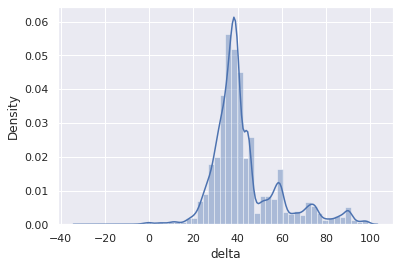

In [ ]:
# Период подачи отчетности
show_filing_period(tmp, 'full_filing_date');

In [ ]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html